In [2]:
%matplotlib inline
import numpy as np
import sympy as sp
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
from scipy.interpolate import interp1d
from scipy.optimize import least_squares

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from rs_models.econ_model import econ_model as em

In [3]:
# Load data
labor = pd.read_csv('../data/Labor/API_SL.TLF.TOTL.IN_DS2_en_csv_v2_59582.csv', header=2)
labor = labor.drop(['Country Code', 'Indicator Name', 'Indicator Code', 'Unnamed: 63'], axis=1)
labor.set_index('Country Name', inplace=True)
labor = labor.transpose().astype(float)
labor.drop(list(labor.index.values[0:5]), inplace=True)
labor['Total'] = labor.sum(axis=1) / 10.
labor.index = labor.index.astype(int)


energy = pd.read_excel('../data/Energy_Consumption/bp-stats-review-2019-all-data.xlsx', sheet_name=1)
energy.set_index('In Mtoe', inplace=True)
energy = energy.dropna().transpose()

gdp = pd.read_csv('../data/GDP/API_NY.GDP.MKTP.CD_DS2_en_csv_v2_40924.csv', header=2)
gdp = gdp.drop(['Country Code', 'Indicator Name', 'Indicator Code', 'Unnamed: 63'], axis=1)
gdp.set_index('Country Name', inplace=True)
gdp = gdp.transpose().astype(float)
gdp.drop(list(gdp.index.values[0:5]), inplace=True)
gdp['Total'] = gdp.sum(axis=1)
gdp.index = gdp.index.astype(int)

In [4]:
data = energy.loc[:,['Fraction Fossil', 'Fraction Renewable', 'Total Fossil', 'Total Renewable']]
data['labor'] = labor['Total']
data['production dirty'] = gdp['Total'] * energy['Fraction Fossil']
data['production clean'] = gdp['Total'] * energy['Fraction Renewable']

# interpolate labor data
dl = data.loc[data['labor']>0]
itp = interp1d(dl.index.values, dl['labor'].values, fill_value='extrapolate')
data['labor'] = [float(itp(x)) for x in data.index.values]

# calculate energy intensity
data['energy intensity'] = data['production dirty'] / data['Total Fossil']

print(data.loc[2010, 'Total Fossil'] + data.loc[2010, 'Total Renewable'], gdp.loc[2010, 'Total'])

# capital income ratio 2010
cir2010 = 4.4

11874.879654277429 534951384196105.6


In [5]:
# capital in each sector as production in each sector times capital income ratio.

clean_capital_2010 = cir2010 * data['production clean'].loc[2010]
dirty_capital_2010 = cir2010 * data['production dirty'].loc[2010]

In [6]:
# set capital depreciation such, that the capital stock is in equilibrium given the current income and savings rate.

s = 0.25  # savings rate

# \dot{K} = s * income - delta * K == 0
# e.g. delta = s * income/K = s/capital income ratio

delta = s/cir2010

In [7]:
# calculate C according to 
# \dot{C} = Yc - chi * C, chi = 0.02

chi = 0.02
C = 0

for Yc in data.loc[range(1965,2011), 'production clean']:
    C += Yc - chi * C

print(C)

779787753829056.2


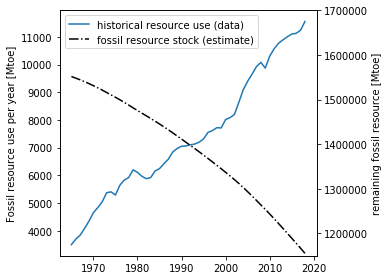

In [10]:
# Estimate current and initial resource stock from fossil resource usage.
fig, ax = plt.subplots()

fig.set_figwidth(5.5)
fig.set_figheight(4)

data['Total Fossil'].plot(ax=ax, label='historical resource use (data)')

fossil_data = data.loc[data['Total Fossil']>0, 'Total Fossil']

# interpolate fossil usage data
#itp = interp1d(fossil_data.index.values, fossil_data.values, fill_value='extrapolate')
#t = range(1948,1965)
#historical_fossil = [float(itp(x)) for x in t]
#ax.plot(t, historical_fossil, 'ko', markersize=.9, label='extrapolated')


ax.set_ylabel('Fossil resource use per year [Mtoe]')

# cumulative historical usage
R_cum = 0
R_cum_t = []
for R in list(fossil_data.values):
    R_cum += R
    R_cum_t.append(R_cum)

# total stock estimated as cumulative historical usage plus another 100 years of current usage:
G1 = 100*fossil_data.values[-1]
G0 = R_cum + G1

# timeseries of fossil resource data as initial resource minus cumulative resource usage
data['Fossil Resource'] = (G0 - R_cum_t)

axb = ax.twinx()
data['Fossil Resource'].plot(ax=axb, color=['k'], style=['-.'], label='fossil resource stock (estimate)')

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = axb.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc=2)

axb.set_ylim([1150000, 1700000])
axb.set_ylabel('remaining fossil resource [Mtoe]')

fig.tight_layout()
fig.savefig('fossil_resource_per_year.pdf')

# so, this rough estimate says, that we have used about one third of the total available amount of fossil fuels. Fair enough.

In [44]:
# load historical oil prices to approximate historical fossil resource cost.

# MWV. (July 25, 2019). Average annual OPEC crude oil price from 1960 to 2019 (in U.S. dollars per barrel) [Chart]. 
# In Statista. Retrieved July 25, 2019, 
# from https://www.statista.com/statistics/262858/change-in-opec-crude-oil-prices-since-1960/

oil_price = pd.read_excel('../data/Oil_Price/statistic_id262858_opec-oil-price-annually-1960-2019.xlsx', sheet_name='Data', header=4)
oil_price.index = oil_price.index.droplevel(0).astype(int)
oil_price.head()

# convert to price per ton
toe_to_barrel = 7.1428571428571
oil_price['Average price in U.S. dollars per ton'] = oil_price['Average price in U.S. dollars per barrel'] * toe_to_barrel

# calculate approx total energy cost as price per ton * total fossil use per year in tons of oil equivalent
data['Fossil resource cost data'] = oil_price['Average price in U.S. dollars per ton'] * data['Total Fossil'] * 10e6
data['dirty production minus resource cost'] = data['production dirty'] - data['Fossil resource cost data']

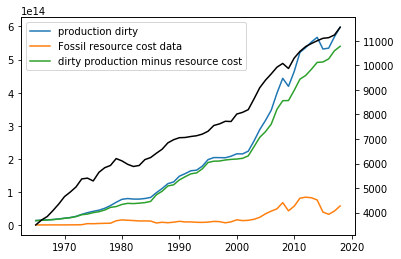

In [45]:
fig, ax = plt.subplots()
data[['production dirty', 'Fossil resource cost data', 'dirty production minus resource cost']].plot(ax=ax, legend=False)
axb = ax.twinx()
data[['Total Fossil']].plot(ax=axb, legend=False, color='k')

ax.legend()

[ 2.46177537e+09 -2.00100000e+00]


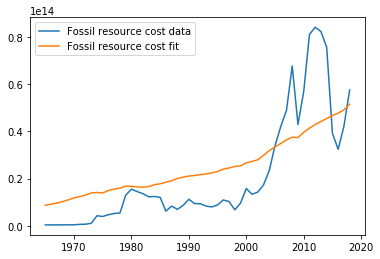

In [46]:
from scipy.optimize import least_squares

def model(*args, **kwargs):
    
    [bR, mu] = args[0]
    
    cRm = [bR * r * (g / kwargs['G0'])**mu for r, g in zip(kwargs['R'], kwargs['G'])]
    
    return [x1 - x2 for x1, x2 in zip(cRm, kwargs['cR'])]

x0 = (10e15, -2)
xlower = (0, -2.001)
#xlower = (0, -8)
xupper = (10e18, -2)

res = least_squares(model, 
                    x0,
                    bounds=(xlower, xupper),
                    kwargs={'G0': G0,
                            'G': list(data['Fossil Resource'].values),
                            'R': list(data['Total Fossil'].values),
                            'cR': list(data['Fossil resource cost data'])
                           })

data['Fossil resource cost fit'] = [res['x'][0] * r * (g / G0)**res['x'][1] for r, g in zip(list(data['Total Fossil'].values), 
                                                                                      list(data['Fossil Resource'].values))]

fig, ax = plt.subplots()
data[['Fossil resource cost data', 'Fossil resource cost fit']].plot(ax=ax)

data.head()

bR, mu = res['x']
print(res['x'])

,Fraction Fossil,Fraction Renewable,Total Fossil,Total Renewable,labor,production dirty,production clean,energy intensity,Fossil Resource,Fossil resource cost data,dirty production minus resource cost,Fossil resource cost fit
1965,0.941339,0.058661,3498.650115,218.025615,1.260900e+09,1.361716e+13,8.485812e+11,3.892117e+09,1.551884e+06,3.548631e+11,1.326229e+13,4.101645e+12
1966,0.940125,0.059875,3697.368563,235.477248,1.305818e+09,1.468139e+13,9.350256e+11,3.970768e+09,1.548187e+06,3.591729e+11,1.432222e+13,4.394119e+12
1967,0.940638,0.059362,3842.392130,242.485178,1.350737e+09,1.556456e+13,9.822464e+11,4.050748e+09,1.544344e+06,3.650273e+11,1.519954e+13,4.631798e+12
1968,0.940937,0.059063,4086.757218,256.529395,1.395656e+09,1.676494e+13,1.052350e+12,4.102259e+09,1.540258e+06,3.853228e+11,1.637961e+13,5.001552e+12
1969,0.940838,0.059162,4350.969966,273.598057,1.440575e+09,1.849692e+13,1.163125e+12,4.251217e+09,1.535907e+06,3.946951e+11,1.810222e+13,5.411710e+12


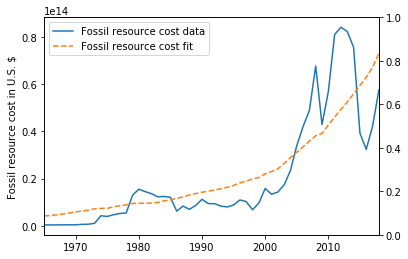

In [66]:
from scipy.optimize import least_squares

def model(*args, **kwargs):
    
    [bR, mu] = args[0]
    
    cRm = [bR * r * (g / kwargs['G0'])**mu for r, g in zip(kwargs['R'], kwargs['G'])]
    
    return [x1 - x2 for x1, x2 in zip(cRm, kwargs['cR'])]

x0 = (10e15, -2)
#xlower = (0, -2.001)
xlower = (0, -8)
xupper = (10e18, -2)

res = least_squares(model, 
                    x0,
                    bounds=(xlower, xupper),
                    kwargs={'G0': G0,
                            'G': list(data['Fossil Resource'].values),
                            'R': list(data['Total Fossil'].values),
                            'cR': list(data['Fossil resource cost data'])
                           })

data['Fossil resource cost fit'] = [res['x'][0] * r * (g / G0)**res['x'][1] for r, g in zip(list(data['Total Fossil'].values), 
                                                                                      list(data['Fossil Resource'].values))]

fig, ax = plt.subplots()
data.columns.name = ''

axb=ax.twinx()
#axb.set_ylim([0,1000])

#oil_price[['Average price in U.S. dollars per ton']].plot(ax=axb, colors=['k'], legend=False)

ax.set_ylabel('Fossil resource cost in U.S. $')

data[['Fossil resource cost data']].plot(ax=ax, legend=False)
data[['Fossil resource cost fit']].plot(ax=ax, style=['--'], legend=False)
ax.set_xlim([min(data.index.values), max(data.index.values)])



lines, labels = axb.get_legend_handles_labels()
lines2, labels2 = ax.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc=2)

fig.savefig('resource_price_fit.pdf')

bR, mu = res['x']
data.head()

[ 3.07887015e+08 -1.19797321e+01]


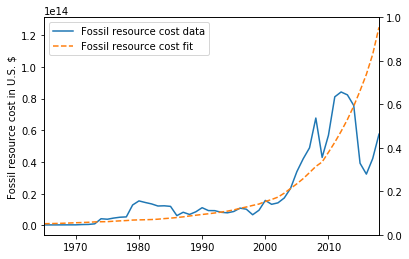

In [65]:
from math import log
def model(*args, **kwargs):
    
    [bR, mu] = args[0]
    
    lncRm = [log(bR) + log(r) + mu * log(g) - mu * log(kwargs['G0']) for r, g in zip(kwargs['R'], kwargs['G'])]
    
    return [x1 - x2 for x1, x2 in zip(lncRm, [log(x) for x in kwargs['cR']])]

x0 = (10e15, -2)
#xlower = (0, -2.001)
xlower = (0, -12)
xupper = (10e18, -2)

res = least_squares(model, 
                    x0,
                    bounds=(xlower, xupper),
                    kwargs={'G0': G0,
                            'G': list(data['Fossil Resource'].values),
                            'R': list(data['Total Fossil'].values),
                            'cR': list(data['Fossil resource cost data'])
                           })

data['Fossil resource cost fit'] = [res['x'][0] * r * (g / G0)**res['x'][1] for r, g in zip(list(data['Total Fossil'].values), 
                                                                                      list(data['Fossil Resource'].values))]

fig, ax = plt.subplots()
data.columns.name = ''

axb=ax.twinx()
#axb.set_ylim([0,1000])

#oil_price[['Average price in U.S. dollars per ton']].plot(ax=axb, colors=['k'], legend=False)

ax.set_ylabel('Fossil resource cost in U.S. $')

data[['Fossil resource cost data']].plot(ax=ax, legend=False)
data[['Fossil resource cost fit']].plot(ax=ax, style=['--'], legend=False)
ax.set_xlim([min(data.index.values), max(data.index.values)])



lines, labels = axb.get_legend_handles_labels()
lines2, labels2 = ax.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc=2)

fig.savefig('resource_price_fit_log.pdf')

data.head()
print(res['x'])

In [48]:
# implement production functions for Yc & Yd

Yc = em.c_expressions[0][em.Yc]
Yd = em.c_expressions[0][em.Yd]

In [49]:
alpha = 2/3
betac = 1/3
betad = 1/3
gamma = 1/8

parameter_substitutions = {em.C: C,
                           em.G0: G0,
                           em.G: G1,
                           em.bR: bR,
                           em.mu: mu,
                           em.Kc: clean_capital_2010,
                           em.Kd: dirty_capital_2010,
                           em.e: data.loc[2010, 'energy intensity'],
                           em.alpha: 2/3,
                           em.betac: 1/3,
                           em.betad: 1/3,
                           em.gamma: 1/8,
                           em.R: data.loc[2010,'Total Fossil'],
                           em.L: data.loc[2010, 'labor']}

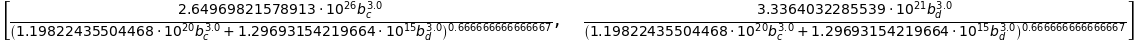

In [67]:
fYc = Yc.subs(parameter_substitutions)
fYd = Yd.subs(parameter_substitutions)
[fYc, fYd]

In [89]:
from scipy.optimize import root
def rfoo(x, Ycd, Ydd):
    psubs = {em.bc: x[0],
             em.bd: x[1]}
    res = [sp.re(sp.Abs(fYc.subs(psubs) - Ycd).evalf()), sp.re(sp.Abs(fYd.subs(psubs) - Ydd).evalf())]
    return res

x_start = (1, 1)

res = root(rfoo, x_start, args=(data.loc[2010, 'production clean'], data.loc[2010, 'production dirty']))
bc, bd = res['x']

rsubs = {em.bc: bc,
         em.bd: bd}

print(fYc.subs(rsubs), fYd.subs(rsubs))
print(data.loc[2010, 'production clean'], data.loc[2010, 'production dirty'])

# rescale bc and bd such that they are independend of the initial values of Kc, Kd, L and C and also independent of the input elasticities.

nbc = bc * data.loc[2010, 'labor']**alpha * clean_capital_2010**betac * C**gamma
nbd = bd * data.loc[2010, 'labor']**alpha * dirty_capital_2010**betad

print(f'$b_c$={nbc:1.4g}, $b_d$={nbd:1.4g}')

70891523934598.8 464059860261507.
70891523934598.78 464059860261506.8
$b_c$=2.501e+14, $b_d$=5.175e+14


In [52]:
fitted_parameters = {'Kc0': clean_capital_2010,
                     'Kd0': dirty_capital_2010,
                     'L': data.loc[2010, 'labor'],
                     'C0': C,
                     'G0': G0,
                     'G1': G1,
                     'bR': bR,
                     'mu': mu,
                     'bc': bc,
                     'bd': bd,
                     's': s,
                     'delta': delta,
                     'e': data.loc[2010, 'energy intensity'],
                     'alpha': alpha,
                     'betac': betac,
                     'betad': betad,
                     'gamma': gamma}

In [53]:
fitted_parameters

{'Kc0': 311922705312234.7,
 'Kd0': 2041863385150630.2,
 'L': 3288420945.5,
 'C0': 779787753829056.2,
 'G0': 1555382.691630107,
 'G1': 1155584.3903578299,
 'bR': 1157356560.9695928,
 'mu': -5.716117940628487,
 'bc': 22.942164883386322,
 'bd': 1844.7333010622006,
 's': 0.25,
 'delta': 0.056818181818181816,
 'e': 45048994159.98814,
 'alpha': 0.6666666666666666,
 'betac': 0.3333333333333333,
 'betad': 0.3333333333333333,
 'gamma': 0.125}

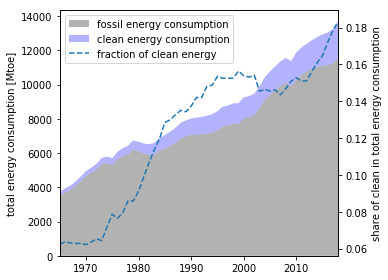

In [24]:
import seaborn as sn

x = [float(d) for d in data.index.values]
y = data[['Total Fossil', 'Total Renewable']].values.T

fig, ax = plt.subplots()
fig.set_figwidth(5.5)
fig.set_figheight(4)
p1 = ax.stackplot(x, y, alpha=0.3, labels=['fossil energy consumption', 'clean energy consumption'], colors=['k', 'b'])
ax.set_xlim([min(x), max(x)])
axb = ax.twinx()

b2 = axb.plot(x, [e / f for e, f in zip(y[1], y[0])], '--', label='fraction of clean energy')

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = axb.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc=2)

ax.set_ylabel('total energy consumption [Mtoe]')
axb.set_ylabel('share of clean in total energy consumption')

fig.tight_layout()

fig.savefig('energy_consumption_clean_dirty.pdf')

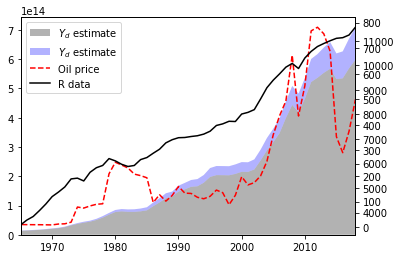

In [20]:
x = [float(d) for d in data.index.values]
y = data[['production dirty', 'production clean']].values.T

fig, ax = plt.subplots()
p1 = ax.stackplot(x, y, alpha=0.3, labels=[r'$Y_d$ estimate', r'$Y_d$ estimate'], colors=['k', 'b'])
#gdp['Total'].plot(ax=ax, label='GDP data')
ax.set_xlim([min(x), max(x)])

axb = ax.twinx()
oil_price['Average price in U.S. dollars per ton'].plot(ax=axb, label='Oil price', color='red', style=['--'])

axc = ax.twinx()
data['Total Fossil'].plot(ax=axc, label='R data', color=['k'])

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = axb.get_legend_handles_labels()
lines3, labels3 = axc.get_legend_handles_labels()
ax.legend(lines + lines2 + lines3, labels + labels2 + labels3, loc=2)

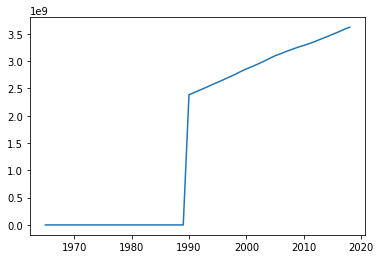

In [21]:
labor['Total'].plot()